<a href="https://colab.research.google.com/github/efra08/lstm-btc/blob/main/fiks_LSTM_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **V1 Sliding Window Autoregressive**

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


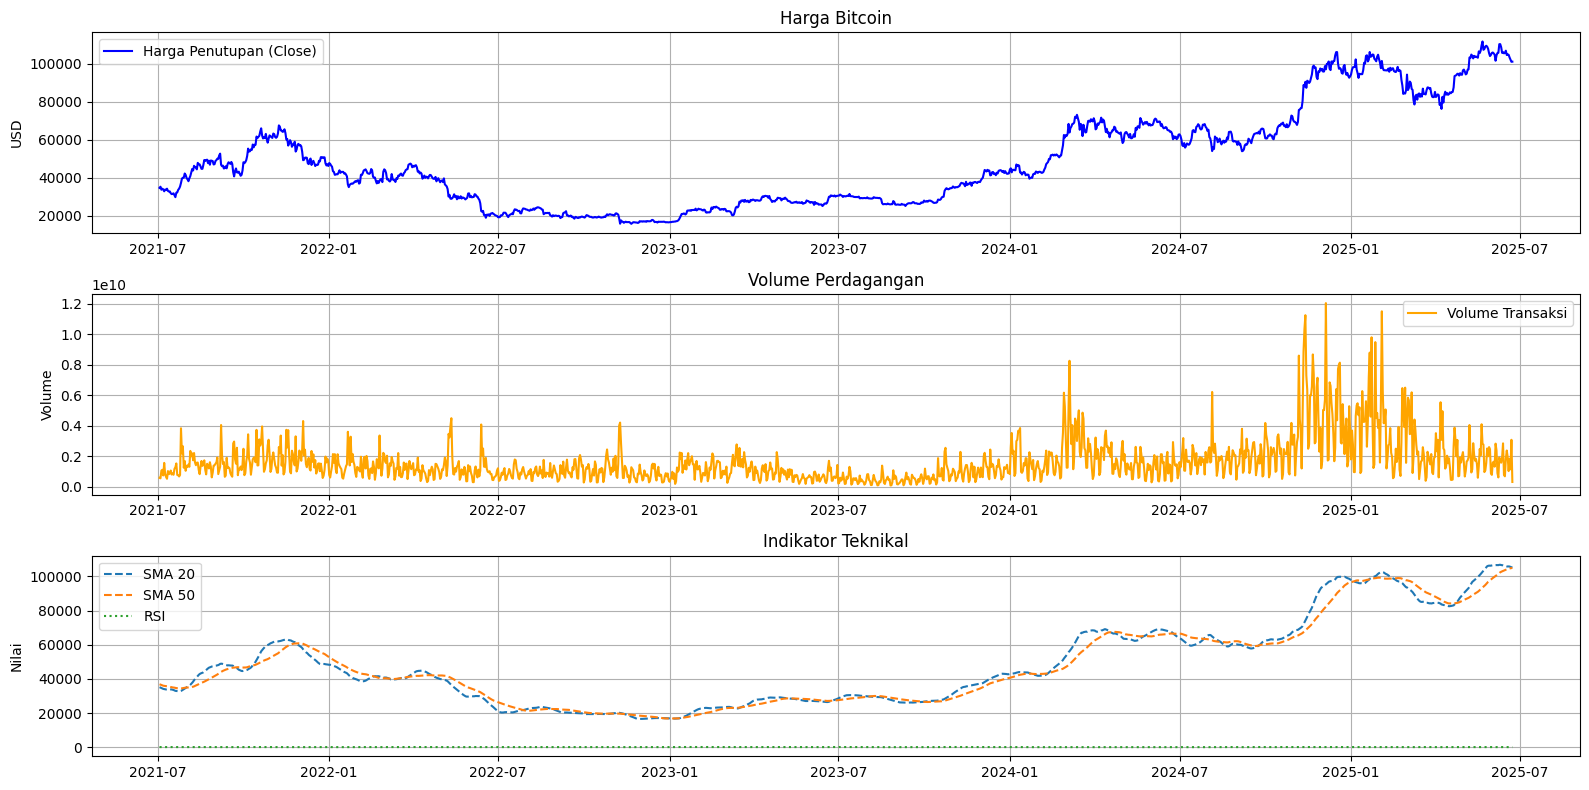

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import os

# ===================== 1. AMBIL DATA HARGA BTC =====================
def download_btc_data():
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {'fsym': 'BTC', 'tsym': 'USD', 'limit': 1500}
    response = requests.get(url, params=params)
    data = pd.DataFrame(response.json()['Data']['Data'])
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data.set_index('time', inplace=True)
    return data

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def add_features(df):
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['close'], 14)
    df['MACD'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()
    df['Upper_BB'] = df['close'].rolling(20).mean() + 2*df['close'].rolling(20).std()
    df['Lower_BB'] = df['close'].rolling(20).mean() - 2*df['close'].rolling(20).std()
    return df.dropna()

df = download_btc_data()
df = add_features(df)

# ===================== VISUALISASI DATA =====================
import matplotlib.dates as mdates

plt.figure(figsize=(16, 8))

# Plot harga penutupan
plt.subplot(3, 1, 1)
plt.plot(df.index, df['close'], label='Harga Penutupan (Close)', color='blue')
plt.title('Harga Bitcoin')
plt.ylabel('USD')
plt.grid(True)
plt.legend()

# Plot volume
plt.subplot(3, 1, 2)
plt.plot(df.index, df['volumeto'], label='Volume Transaksi', color='orange')
plt.title('Volume Perdagangan')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()

# Plot indikator teknikal
plt.subplot(3, 1, 3)
plt.plot(df.index, df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(df.index, df['SMA_50'], label='SMA 50', linestyle='--')
plt.plot(df.index, df['RSI'], label='RSI', linestyle=':')
plt.title('Indikator Teknikal')
plt.ylabel('Nilai')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Trial 50 Complete [00h 00m 19s]
val_loss: 0.0007744355825707316

Best val_loss So Far: 0.0005986802862025797
Total elapsed time: 00h 16m 58s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
RMSE: 4150.32
MAE: 3319.27
MAPE: 3.60%


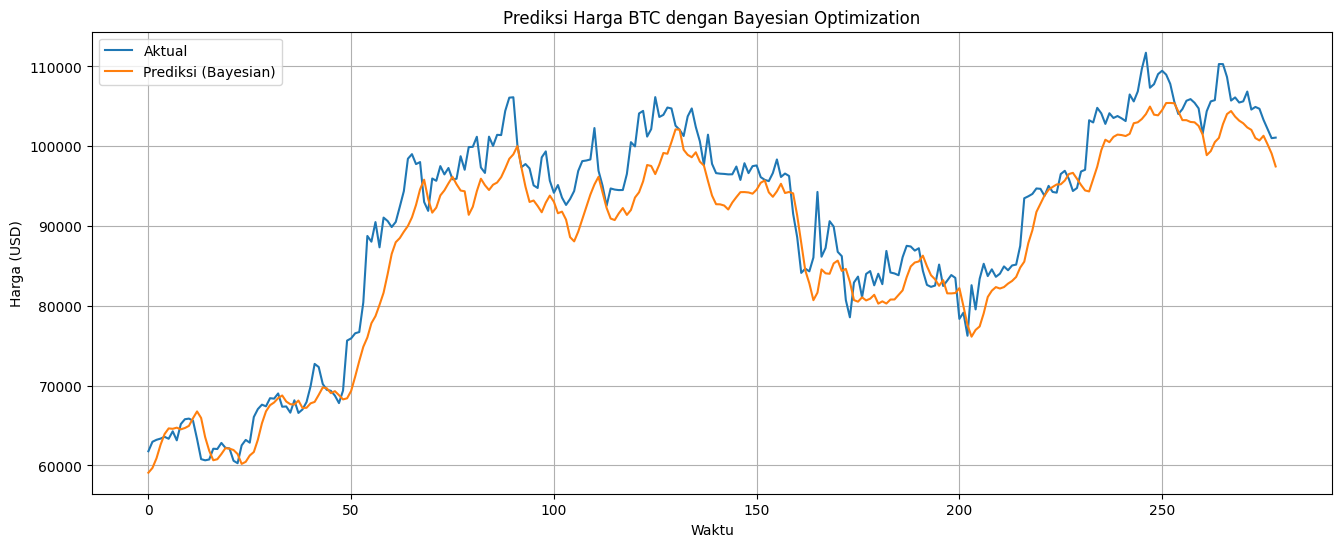

In [ ]:
# ===================== 2. NORMALISASI & WINDOWING =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import joblib

FEATURES = ['close', 'volumeto', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Upper_BB', 'Lower_BB']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[FEATURES])
joblib.dump(scaler, 'scaler_btc.pkl')

close_idx = FEATURES.index('close')

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, close_idx])  # Hanya target close
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size=60)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# ===================== 3. DEFINISI MODEL UNTUK TUNING =====================
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(
        hp.Int('units_1', min_value=64, max_value=256, step=32),
        return_sequences=True
    )))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(Bidirectional(LSTM(
        hp.Int('units_2', min_value=32, max_value=128, step=32)
    )))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))  # Output hanya harga close
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

# ===================== 4. BAYESIAN OPTIMIZATION TUNING =====================
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,  # Cukup efisien dengan Bayesian
    directory='tuner_dir',
    project_name='btc_lstm_bayesian'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# ===================== 5. EVALUASI MODEL TERBAIK =====================
best_model = tuner.get_best_models(1)[0]
best_model.compile(optimizer=Adam(), loss='mse')  # Compile ulang untuk menghindari optimizer warning

predicted = best_model.predict(X_test)

# Inverse transform hanya untuk kolom close
dummy_pred = np.zeros((len(predicted), len(FEATURES)))
dummy_pred[:, close_idx] = predicted[:, 0]
predicted_inv = scaler.inverse_transform(dummy_pred)[:, close_idx]

dummy_true = np.zeros((len(y_test), len(FEATURES)))
dummy_true[:, close_idx] = y_test
y_test_inv = scaler.inverse_transform(dummy_true)[:, close_idx]

close_pred = predicted_inv
close_true = y_test_inv

print(f"RMSE: {np.sqrt(mean_squared_error(close_true, close_pred)):.2f}")
print(f"MAE: {mean_absolute_error(close_true, close_pred):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(close_true, close_pred) * 100:.2f}%")

plt.figure(figsize=(16, 6))
plt.plot(close_true, label='Aktual')
plt.plot(close_pred, label='Prediksi (Bayesian)')
plt.title('Prediksi Harga BTC dengan Bayesian Optimization')
plt.xlabel('Waktu')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
tuner.get_best_models(num_models=1)[0].save("best_model_btc.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature

📈 Prediksi harga BTC untuk 7 hari ke depan (Sliding Window Autoregressive):
            predicted_close
date                       
2025-06-25     98308.445591
2025-06-26     97257.156454
2025-06-27     96559.252246
2025-06-28     95747.129829
2025-06-29     95006.258664
2025-06-30     94202.081016
2025-07-01     93094.320528


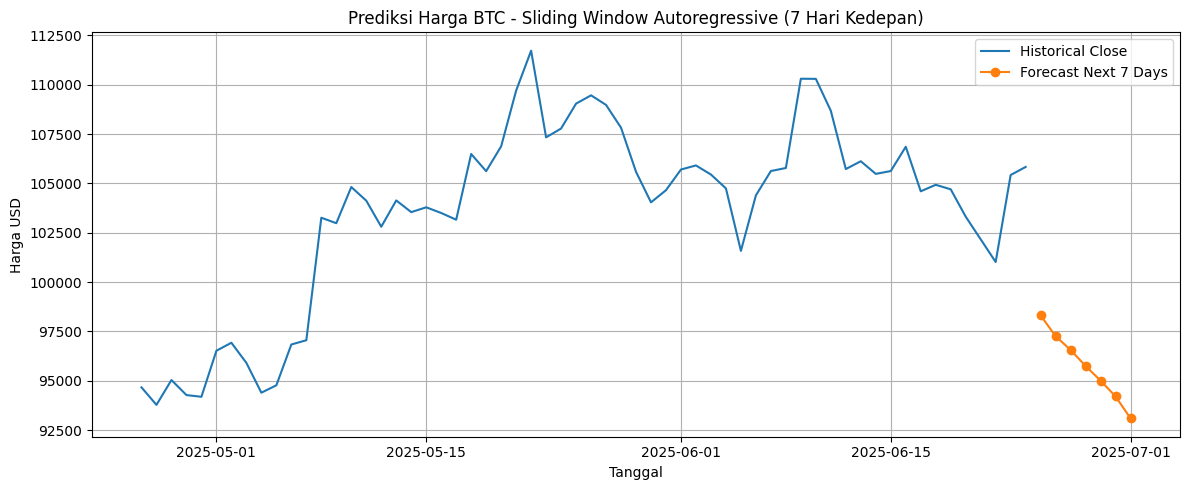

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model

# ===================== 1. AMBIL DATA TERBARU =====================
def download_btc_data():
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {'fsym': 'BTC', 'tsym': 'USD', 'limit': 200}
    response = requests.get(url, params=params)
    data = pd.DataFrame(response.json()['Data']['Data'])
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data.set_index('time', inplace=True)
    return data

# ===================== 2. FITUR TEKNIKAL =====================
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def add_features(df):
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['close'], 14)
    df['MACD'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()
    df['Upper_BB'] = df['close'].rolling(20).mean() + 2 * df['close'].rolling(20).std()
    df['Lower_BB'] = df['close'].rolling(20).mean() - 2 * df['close'].rolling(20).std()
    return df.dropna()

# ===================== 3. AUTOREGRESSIVE PREDICTION =====================
def predict_next_7_days(df, model, scaler, window_size=60):
    FEATURES = ['close', 'volumeto', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Upper_BB', 'Lower_BB']
    preds = []

    future_df = df.copy()

    for _ in range(7):
        current_window = future_df[FEATURES].values[-window_size:]
        if current_window.shape[0] < window_size:
            raise ValueError(f"Data tidak cukup untuk window size {window_size}")

        input_scaled = scaler.transform(current_window)
        input_scaled = input_scaled.reshape(1, window_size, len(FEATURES))

        pred_close_scaled = model.predict(input_scaled, verbose=0)[0][0]

        dummy = np.zeros((1, len(FEATURES)))
        dummy[0, FEATURES.index('close')] = pred_close_scaled
        pred_close_actual = scaler.inverse_transform(dummy)[0][FEATURES.index('close')]
        preds.append(pred_close_actual)

        next_index = future_df.index[-1] + pd.Timedelta(days=1)

        next_row = {
            'close': pred_close_actual,
            'volumeto': future_df['volumeto'].values[-1]
        }

        future_df = pd.concat([future_df, pd.DataFrame([next_row], index=[next_index])])

        future_df.loc[next_index, 'SMA_20'] = future_df['close'].iloc[-20:].mean() if len(future_df) >= 20 else np.nan
        future_df.loc[next_index, 'SMA_50'] = future_df['close'].iloc[-50:].mean() if len(future_df) >= 50 else np.nan
        future_df.loc[next_index, 'RSI'] = compute_rsi(future_df['close'], 14).iloc[-1] if len(future_df) >= 15 else np.nan
        future_df.loc[next_index, 'MACD'] = future_df['close'].ewm(span=12).mean().iloc[-1] - future_df['close'].ewm(span=26).mean().iloc[-1]
        future_df.loc[next_index, 'Upper_BB'] = future_df['close'].iloc[-20:].mean() + 2 * future_df['close'].iloc[-20:].std() if len(future_df) >= 20 else np.nan
        future_df.loc[next_index, 'Lower_BB'] = future_df['close'].iloc[-20:].mean() - 2 * future_df['close'].iloc[-20:].std() if len(future_df) >= 20 else np.nan

    return np.array(preds)

# ===================== 4. MAIN =====================
if __name__ == '__main__':
    FEATURES = ['close', 'volumeto', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Upper_BB', 'Lower_BB']

    df = download_btc_data()
    df = add_features(df)

    try:
        scaler = joblib.load('scaler_btc.pkl')
        model = load_model('best_model_btc.keras')
    except Exception as e:
        print(f"❌ Gagal memuat model atau scaler: {e}")
        exit()

    pred_7day = predict_next_7_days(df, model, scaler)

    today = df.index[-1]
    future_dates = pd.date_range(start=today + pd.Timedelta(days=1), periods=7)

    forecast_df = pd.DataFrame({'date': future_dates, 'predicted_close': pred_7day}).set_index('date')

    print("📈 Prediksi harga BTC untuk 7 hari ke depan (Sliding Window Autoregressive):")
    print(forecast_df)

    plt.figure(figsize=(12, 5))
    plt.plot(df['close'][-60:], label='Historical Close')
    plt.plot(forecast_df['predicted_close'], label='Forecast Next 7 Days', marker='o')
    plt.title("Prediksi Harga BTC - Sliding Window Autoregressive (7 Hari Kedepan)")
    plt.xlabel("Tanggal")
    plt.ylabel("Harga USD")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# **V2 Multi-Output Forecasting**






In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.4 MB/s eta 0:00:00


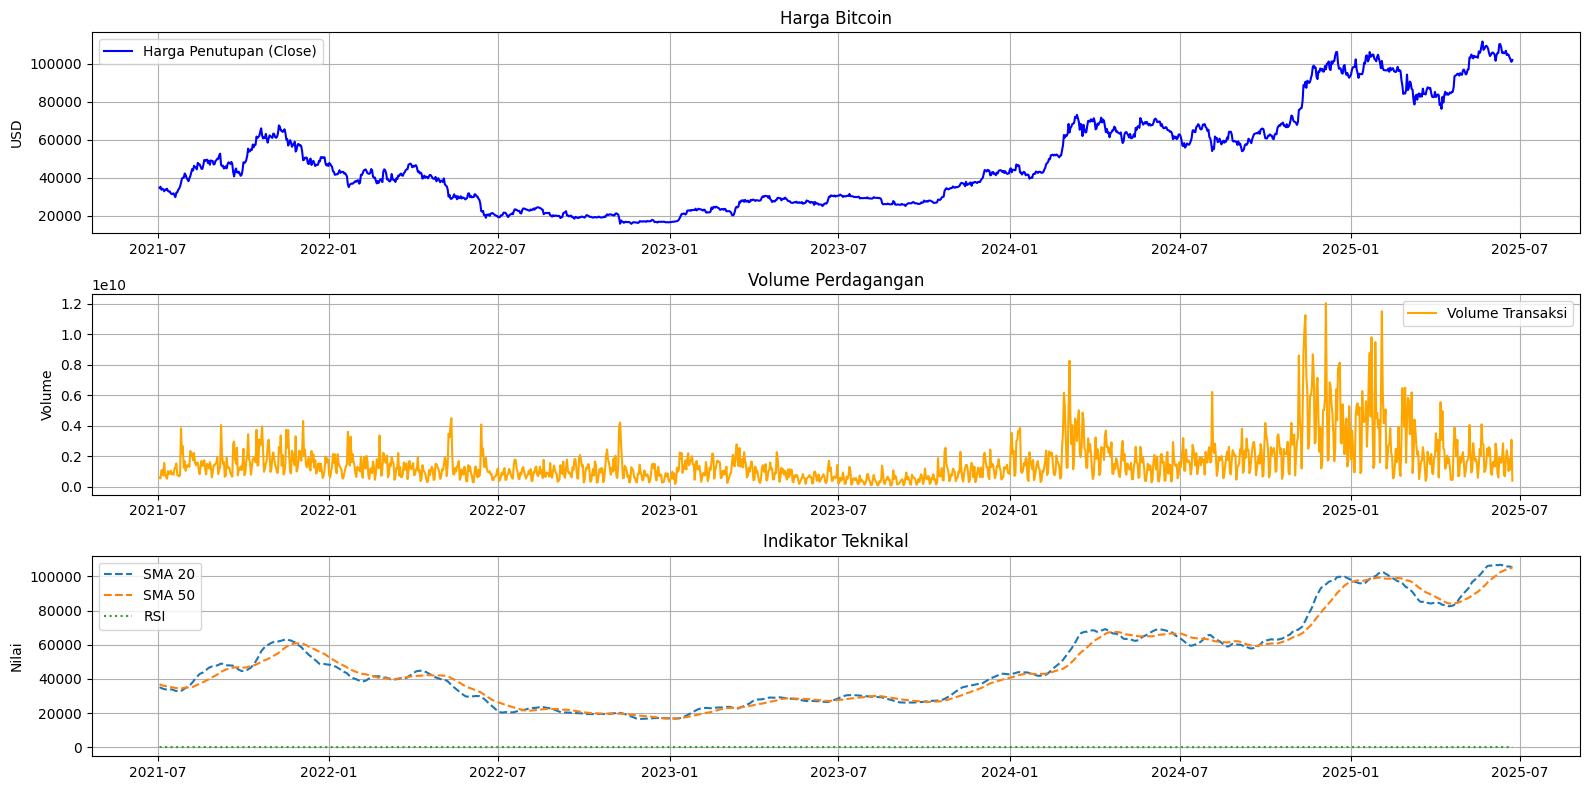

In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import os

# ===================== 1. AMBIL DATA HARGA BTC =====================
def download_btc_data():
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {'fsym': 'BTC', 'tsym': 'USD', 'limit': 1500}
    response = requests.get(url, params=params)
    data = pd.DataFrame(response.json()['Data']['Data'])
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data.set_index('time', inplace=True)
    return data

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def add_features(df):
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['close'], 14)
    df['MACD'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()
    df['Upper_BB'] = df['close'].rolling(20).mean() + 2*df['close'].rolling(20).std()
    df['Lower_BB'] = df['close'].rolling(20).mean() - 2*df['close'].rolling(20).std()
    return df.dropna()

df = download_btc_data()
df = add_features(df)

# ===================== VISUALISASI DATA =====================
import matplotlib.dates as mdates

plt.figure(figsize=(16, 8))

# Plot harga penutupan
plt.subplot(3, 1, 1)
plt.plot(df.index, df['close'], label='Harga Penutupan (Close)', color='blue')
plt.title('Harga Bitcoin')
plt.ylabel('USD')
plt.grid(True)
plt.legend()

# Plot volume
plt.subplot(3, 1, 2)
plt.plot(df.index, df['volumeto'], label='Volume Transaksi', color='orange')
plt.title('Volume Perdagangan')
plt.ylabel('Volume')
plt.grid(True)
plt.legend()

# Plot indikator teknikal
plt.subplot(3, 1, 3)
plt.plot(df.index, df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(df.index, df['SMA_50'], label='SMA 50', linestyle='--')
plt.plot(df.index, df['RSI'], label='RSI', linestyle=':')
plt.title('Indikator Teknikal')
plt.ylabel('Nilai')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ===================== 2. NORMALISASI & WINDOWING =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import joblib

FEATURES = ['close', 'volumeto', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Upper_BB', 'Lower_BB']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[FEATURES])
joblib.dump(scaler, 'scaler_btc_multi.pkl')

def create_multi_output_sequences(data, window_size=60, forecast_horizon=7):
    X, y = [], []
    close_idx = FEATURES.index('close')

    for i in range(window_size, len(data) - forecast_horizon + 1):
        X.append(data[i - window_size:i])
        # Ambil 7 hari harga close ke depan
        y.append(data[i:i + forecast_horizon, close_idx])

    return np.array(X), np.array(y)


# ===================== 3. DEFINISI MODEL UNTUK TUNING =====================
def build_multi_output_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(
        hp.Int('units_1', min_value=64, max_value=256, step=32),
        return_sequences=True
    )))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(Bidirectional(LSTM(
        hp.Int('units_2', min_value=32, max_value=128, step=32)
    )))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))
    model.add(Dense(7))  # Output 7 hari ke depan (multi-output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

# ===================== 4. BAYESIAN OPTIMIZATION TUNING =====================
# Buat dataset multi-output
X, y = create_multi_output_sequences(scaled_data, window_size=60, forecast_horizon=7)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Tuning model dengan Bayesian Optimization
tuner = kt.BayesianOptimization(
    build_multi_output_model,
    objective='val_loss',
    max_trials=50,
    directory='tuner_dir',
    project_name='btc_lstm_multioutput'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])


# ===================== 5. EVALUASI MODEL TERBAIK =====================
best_model = tuner.get_best_models(1)[0]
best_model.compile(optimizer=Adam(), loss='mse')  # Compile ulang agar aman

# Prediksi di test set
predicted = best_model.predict(X_test)  # shape (samples, 7)

# Karena scaler transform semua fitur, kita buat dummy array untuk inverse transform
def inverse_transform_close(scaled_close):
    dummy = np.zeros((len(scaled_close), len(FEATURES)))
    close_idx = FEATURES.index('close')
    dummy[:, close_idx] = scaled_close
    return scaler.inverse_transform(dummy)[:, close_idx]

predicted_inv = inverse_transform_close(predicted)
y_test_inv = inverse_transform_close(y_test)

# Hitung metrik untuk tiap horizon hari (7 hari)
for i in range(predicted.shape[1]):
    rmse = np.sqrt(mean_squared_error(y_test_inv[:, i], predicted_inv[:, i]))
    mae = mean_absolute_error(y_test_inv[:, i], predicted_inv[:, i])
    mape = mean_absolute_percentage_error(y_test_inv[:, i], predicted_inv[:, i]) * 100
    print(f"Horizon +{i+1} hari → RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

# Plot actual vs predicted untuk beberapa sample
plt.figure(figsize=(16, 8))
sample_idx = 0  # contoh ambil sample pertama dari test set
plt.plot(range(1, 8), y_test_inv[sample_idx], marker='o', label='Aktual')
plt.plot(range(1, 8), predicted_inv[sample_idx], marker='o', label='Prediksi')
plt.title('Contoh Prediksi Harga Close BTC untuk 7 Hari ke Depan')
plt.xlabel('Hari ke depan')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)
plt.show()

Trial 50 Complete [00h 03m 07s]
val_loss: 0.002815841231495142

Best val_loss So Far: 0.001354144187644124
Total elapsed time: 03h 15m 47s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step


ValueError: could not broadcast input array from shape (278,7) into shape (278,)

In [ ]:
tuner.get_best_models(num_models=1)[0].save("best_model_btc_multi.keras")

In [ ]:
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
import requests
import numpy as np

# Load scaler dan model terbaik yang sudah disimpan
scaler = joblib.load('scaler_btc_multi.pkl')
model = load_model('best_model_btc_multi.keras')


# Fungsi download data
def download_btc_data():
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {'fsym': 'BTC', 'tsym': 'USD', 'limit': 200}
    response = requests.get(url, params=params)
    data = pd.DataFrame(response.json()['Data']['Data'])
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data.set_index('time', inplace=True)
    return data

# Fungsi teknikal
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def add_features(df):
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    df['RSI'] = compute_rsi(df['close'], 14)
    df['MACD'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()
    df['Upper_BB'] = df['close'].rolling(20).mean() + 2 * df['close'].rolling(20).std()
    df['Lower_BB'] = df['close'].rolling(20).mean() - 2 * df['close'].rolling(20).std()
    return df.dropna()


# Fungsi prediksi
def predict_next_7_days_multioutput(df, model, scaler, window_size=60):
    FEATURES = ['close', 'volumeto', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Upper_BB', 'Lower_BB']
    close_idx = FEATURES.index('close')

    current_window = df[FEATURES].values[-window_size:]
    input_scaled = scaler.transform(current_window)
    input_scaled = input_scaled.reshape(1, window_size, len(FEATURES))

    pred_scaled = model.predict(input_scaled)[0]  # Output: 7 hari ke depan (scaled)

    # Inverse transform khusus kolom close
    dummy = np.zeros((7, len(FEATURES)))
    dummy[:, close_idx] = pred_scaled
    preds_inv = scaler.inverse_transform(dummy)[:, close_idx]

    return preds_inv

# Main
if __name__ == '__main__':
    df = download_btc_data()
    df = add_features(df)

    if len(df) < 60:
        print("❌ Data tidak cukup untuk prediksi.")
        exit()

    pred_7day = predict_next_7_days_multioutput(df, model, scaler)

    today = df.index[-1]
    future_dates = pd.date_range(start=today + pd.Timedelta(days=1), periods=7)
    forecast_df = pd.DataFrame({'date': future_dates, 'predicted_close': pred_7day}).set_index('date')

    print("📈 Prediksi harga BTC untuk 7 hari ke depan:")
    print(forecast_df)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(df['close'][-60:], label='Historical Close')
    plt.plot(forecast_df['predicted_close'], label='Predicted Close (Next 7 Days)', marker='o')
    plt.title("Prediksi Harga BTC - 7 Hari ke Depan (Multi-Output)")
    plt.xlabel("Tanggal")
    plt.ylabel("Harga (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()


# **V3**

                 high        low       open  volumefrom      volumeto  \
time                                                                    
2022-06-14   23214.28   20837.64   22471.59    93509.58  2.063909e+09   
2022-06-15   22743.84   20083.90   22118.37   118629.55  2.516137e+09   
2022-06-16   22961.17   20209.17   22566.73    62443.29  1.326877e+09   
2022-06-17   21330.50   20221.24   20372.85    63610.58  1.312457e+09   
2022-06-18   20722.69   17600.75   20432.26   100138.03  1.898531e+09   
...               ...        ...        ...         ...           ...   
2025-06-08  106537.25  105042.03  105625.23     5871.71  6.216673e+08   
2025-06-09  110543.89  105372.62  105779.28    17851.91  1.927021e+09   
2025-06-10  110403.60  108373.44  110302.12    15646.83  1.712252e+09   
2025-06-11  110425.64  108096.82  110296.20    14497.20  1.585493e+09   
2025-06-12  108843.81  105721.73  108676.78    18051.35  1.937274e+09   

                price conversionType conversionSym

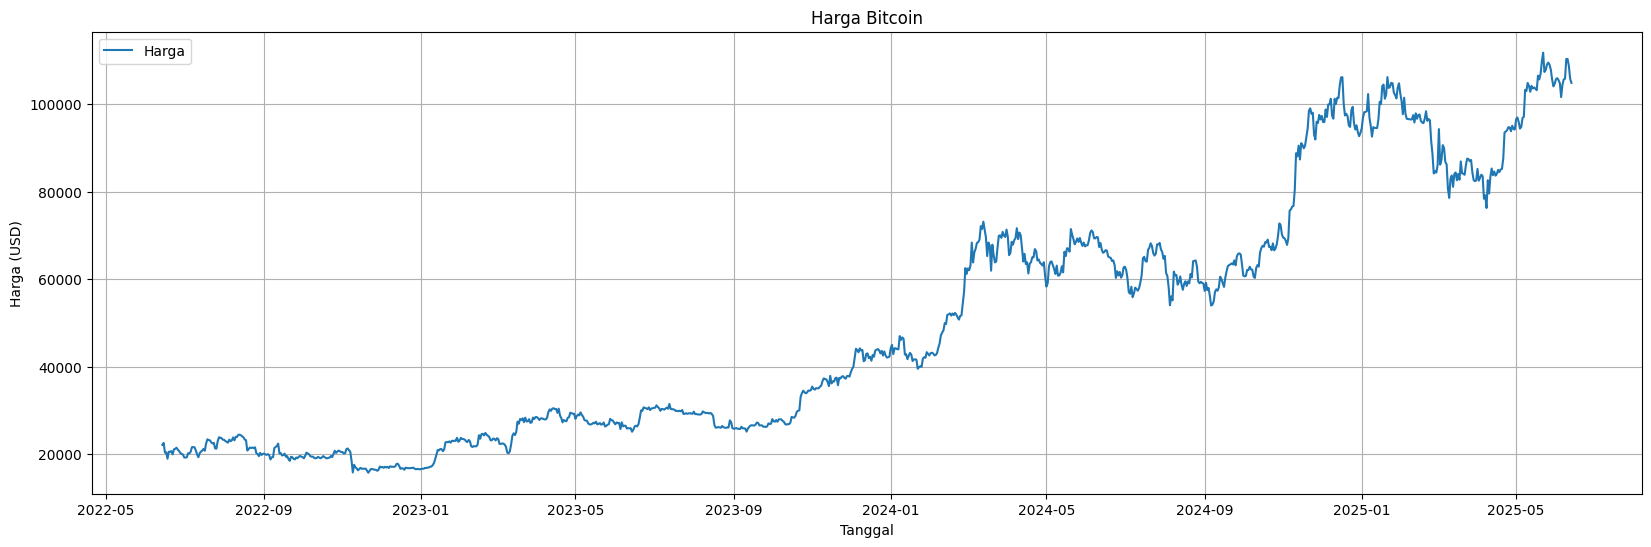

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import numpy as np

# Fungsi untuk mengunduh data harga Shiba Inu dari API CryptoCompare
def unduh_data_shiba_inu():
    try:
        # URL untuk mengunduh data harga Shiba Inu dari API CryptoCompare
        url = 'https://min-api.cryptocompare.com/data/v2/histoday'

        # Parameter untuk menentukan kriptokurensi, mata uang, dan rentang waktu
        params = {
            'fsym': 'BTC',       # Simbol kriptokurensi (Shiba Inu)
            'tsym': 'USD',        # Simbol mata uang (Dolar AS)
            'limit': 365 * 3,     # Batasi jumlah titik data yang diunduh (365 hari * 2 tahun)
            'aggregate': 1,       # Agregasi data pada interval harian
            'toTs': pd.Timestamp.now().strftime('%s')  # Timestamp akhir (waktu saat ini)
        }

        # Kirim permintaan GET untuk mengunduh data harga Shiba Inu
        respons = requests.get(url, params=params)

        # Periksa apakah permintaan berhasil
        if respons.status_code == 200:
            # Konversi data JSON menjadi DataFrame Pandas
            data_shiba_inu = pd.DataFrame(respons.json()['Data']['Data'])
            # Konversi timestamp ke format datetime
            data_shiba_inu['time'] = pd.to_datetime(data_shiba_inu['time'], unit='s')
            # Atur kolom timestamp sebagai indeks
            data_shiba_inu.set_index('time', inplace=True)
            # Ubah nama kolom harga
            data_shiba_inu.rename(columns={'close': 'price'}, inplace=True)
            return data_shiba_inu
        else:
            print("Gagal mengunduh data. Kode status:", respons.status_code)
            return None
    except Exception as e:
        print("Terjadi kesalahan:", e)
        return None

# Unduh data harga Shiba Inu
btc_data = unduh_data_shiba_inu()

# Periksa apakah data berhasil diunduh sebelum mencoba menampilkannya
if btc_data is not None:
    # Tampilkan lima baris pertama dari data
    print(btc_data.head(1095))

    # Plot data harga Shiba Inu
    plt.figure(figsize=(20, 6))
    plt.plot(btc_data.index, btc_data['price'], label='Harga')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (USD)')
    plt.title('Harga Bitcoin')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Pra-pemrosesan data
scaler = MinMaxScaler()
btc_data['scaled_price'] = scaler.fit_transform(btc_data['price'].values.reshape(-1,1))

# Bagi btc_data menjadi data pelatihan dan pengujian
train_size = int(len(btc_data) * 0.7)
train_data = btc_data.iloc[:train_size]
test_data = btc_data.iloc[train_size:]


# Tampilkan jumlah data pelatihan dan pengujian
print("Jumlah data pelatihan:", len(train_data))
print("Jumlah data pengujian:", len(test_data))

Jumlah data pelatihan: 767
Jumlah data pengujian: 329


In [ ]:
# Fungsi untuk membuat dataset dengan time step
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Tentukan time step
time_step = 28


# Membuat dataset untuk pelatihan dan pengujian
X_train, y_train = create_dataset(train_data[['scaled_price']].values, time_step)
X_test, y_test = create_dataset(test_data[['scaled_price']].values, time_step)

print("Dimensi X_test sebelum reshape:", X_test.shape)

# Ubah dimensi untuk sesuai dengan yang dibutuhkan oleh model LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


Dimensi X_test sebelum reshape: (301, 28)


In [ ]:
# # Membangun model LSTM
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))
# optimizer = Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# # Tampilkan arsitektur model
# print(model.summary())

# Definisikan model
model = Sequential()

# Tambahkan layer LSTM dengan dropout dan regularisasi L2
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Tambahkan layer LSTM kedua dengan dropout dan regularisasi L2
model.add(LSTM(units=50, return_sequences=True,))
model.add(Dropout(0.2))

# # Tambahkan layer LSTM kedua dengan dropout dan regularisasi L2
# model.add(LSTM(units=50, return_sequences=True,))
# # model.add(Dropout(0.2))

# Tambahkan layer LSTM ketiga dengan dropout dan regularisasi L2
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Tambahkan layer Dense dengan 1 neuron sebagai output layer
model.add(Dense(units=1))

# Kompilasi model dengan optimizer Adam dan loss function MSE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
# model.compile(optimizer='adam', loss='mean_squared_error')
# Tampilkan ringkasan model
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 28, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 28, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 28, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 28, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Latih model
model.fit(X_train, y_train, epochs=150, batch_size=64, verbose=1)

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0425
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 11/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 13/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 14/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 15/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss:

In [ ]:
# Lakukan prediksi
predictions = model.predict(X_test)

result = model.evaluate(X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018      


In [ ]:
MAPE = mean_absolute_percentage_error(y_test, predictions)
Accuracy = 1 - MAPE

In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.002647963585332036
Test MAPE: 0.05387453428352765
Test Accuracy: 0.9461254657164724


In [ ]:

# Inversi transformasi untuk mendapatkan harga asli
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


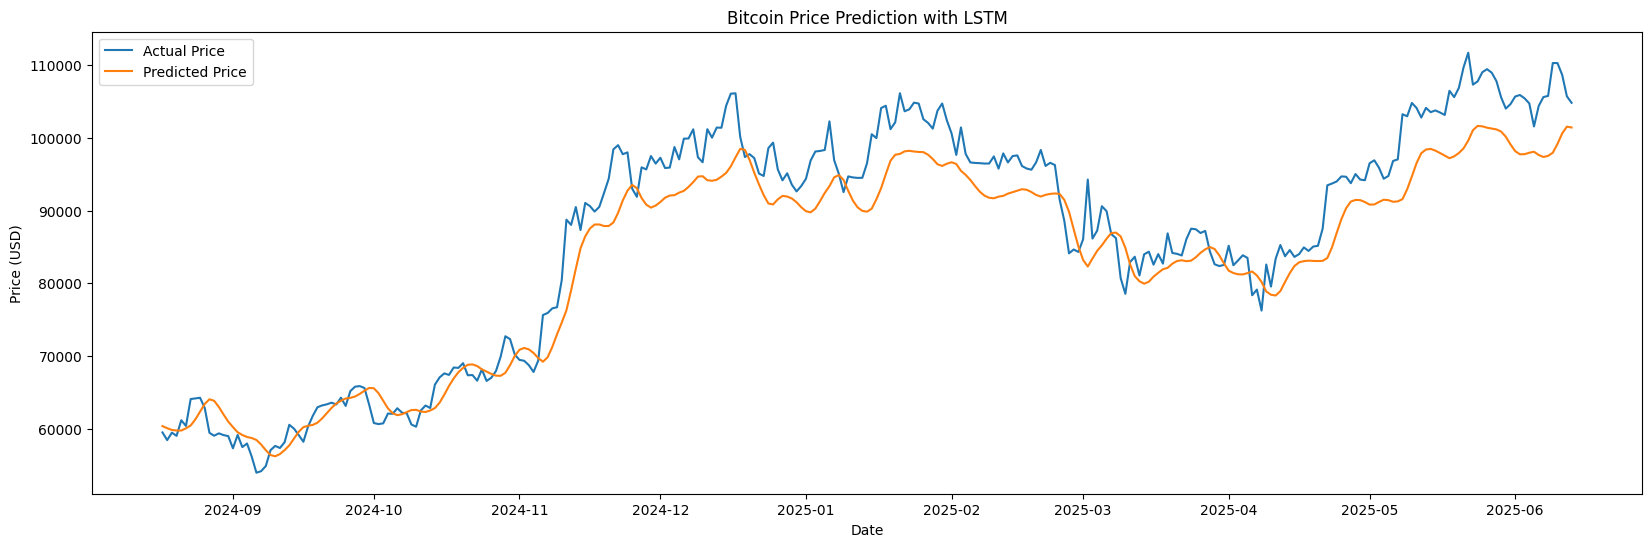

In [ ]:
# Visualisasi hasil prediksi
plt.figure(figsize=(20, 6))
plt.plot(test_data.index[time_step:], y_test, label='Actual Price')
plt.plot(test_data.index[time_step:], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price Prediction with LSTM')
plt.legend()
plt.show()

In [ ]:
# Simpan model ke file
model.save('/content/gdrive/My Drive/file/LSTMBTC.keras')

In [ ]:
# from tensorflow.keras.models import load_model

# Memuat kembali model
loaded_model = load_model('/content/gdrive/My Drive/file/LSTMBTC.keras')

# # # Gunakan model untuk prediksi atau evaluasi
# predictions = loaded_model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediksi harga Bitcoin untuk 7 hari ke depan:
Tanggal 2025-06-14 : 100566.81
Tanggal 2025-06-15 : 98800.65
Tanggal 2025-06-16 : 96624.61
Tanggal 2025-06-17 : 94370.12
Tanggal 2025-06-18 : 92219.766
Tanggal 2025-06-19 : 90258.85
Tanggal 2025-06-20 : 88519.44


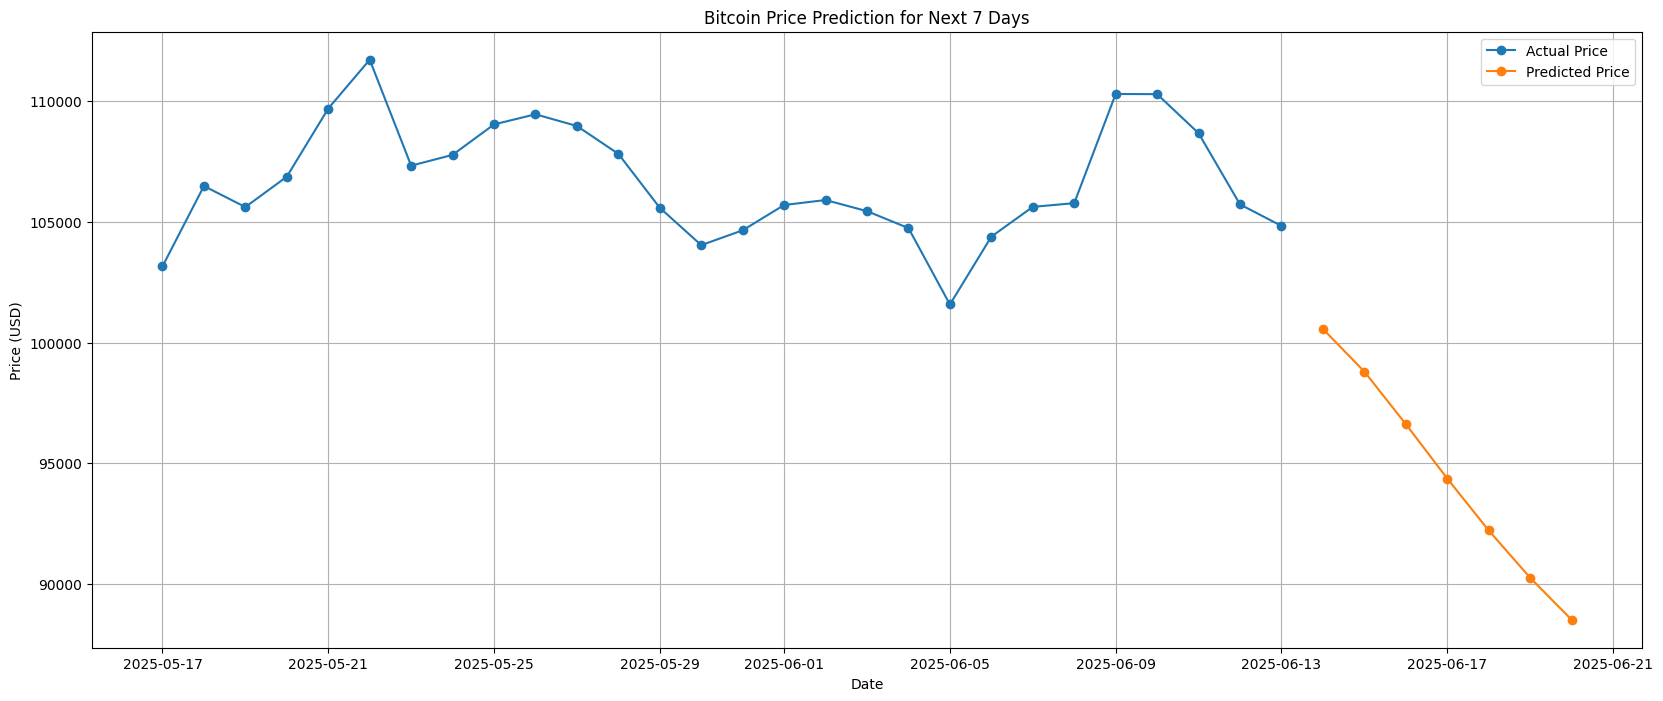

In [ ]:
from datetime import datetime, timedelta

# Mendapatkan tanggal terakhir data yang tersedia
last_date = btc_data.index[-1]

# Menghitung tanggal mulai prediksi (besok dari tanggal terakhir data yang tersedia)
start_date = last_date + timedelta(days=1)

# Jumlah hari ke depan yang ingin diprediksi
days_to_predict = 7

# Persiapkan data input untuk prediksi
last_known_prices = btc_data['price'].values[-time_step:]  # Ambil harga terakhir dari data yang tersedia
input_data = scaler.transform(last_known_prices.reshape(-1, 1).astype(float))  # Normalisasi data input
input_data = np.reshape(input_data, (1, time_step, 1))  # Ubah dimensi input

# Lakukan prediksi untuk setiap hari ke depan
predictions = []
for _ in range(days_to_predict):
    # Lakukan prediksi harga di hari berikutnya
    next_day_prediction = loaded_model.predict(input_data)
    predictions.append(next_day_prediction[0][0])  # Simpan prediksi harga
    # Update input_data dengan harga yang diprediksi untuk digunakan dalam prediksi berikutnya
    input_data = np.append(input_data[:,1:,:], next_day_prediction.reshape(1,1,1), axis=1)

# Lakukan inversi transformasi untuk mendapatkan harga dalam skala aslinya
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Tampilkan hasil prediksi dengan tanggal sekarang
print("Prediksi harga Bitcoin untuk", days_to_predict, "hari ke depan:")
for i, pred in enumerate(predictions, start=1):
    next_date = start_date + timedelta(days=i-1)
    print("Tanggal", next_date.strftime('%Y-%m-%d'), ":", pred[0])

# Plot actual prices and predicted prices
plt.figure(figsize=(20, 8))
plt.plot(btc_data.index[-time_step:], btc_data['price'].values[-time_step:], label='Actual Price', marker='o')
plt.plot(pd.date_range(start=start_date, periods=days_to_predict, freq='D'), predictions, label='Predicted Price', marker='o')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price Prediction for Next ' + str(days_to_predict) + ' Days')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from datetime import datetime, timedelta

# Mendapatkan tanggal terakhir data yang tersedia
last_date = btc_data.index[-1]

# Menghitung tanggal mulai prediksi (besok dari tanggal terakhir data yang tersedia)
start_date = last_date + timedelta(days=1)

# Jumlah bulan ke depan yang ingin diprediksi
months_to_predict = 12

# Persiapkan data input untuk prediksi
last_known_prices = btc_data['price'].values[-time_step:]  # Ambil harga terakhir dari data yang tersedia
input_data = scaler.transform(last_known_prices.reshape(-1, 1).astype(float))  # Normalisasi data input
input_data = np.reshape(input_data, (1, time_step, 1))  # Ubah dimensi input

# Lakukan prediksi untuk setiap bulan ke depan
predictions = []
for _ in range(months_to_predict):
    # Lakukan prediksi harga di bulan berikutnya
    next_month_prediction = loaded_model.predict(input_data)
    predictions.append(next_month_prediction[0][0])  # Simpan prediksi harga
    # Update input_data dengan harga yang diprediksi untuk digunakan dalam prediksi berikutnya
    input_data = np.append(input_data[:,1:,:], next_month_prediction.reshape(1,1,1), axis=1)

# Lakukan inversi transformasi untuk mendapatkan harga dalam skala aslinya
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Tampilkan hasil prediksi dengan bulan sekarang
print("Prediksi harga Bitcoin untuk", months_to_predict, "bulan ke depan:")
for i, pred in enumerate(predictions, start=1):
    next_month = start_date + pd.DateOffset(months=i-1)
    print("Bulan", next_month.strftime('%Y-%m'), ":", pred[0])

# Plot actual prices and predicted prices
plt.figure(figsize=(20, 8))
plt.plot(btc_data.index[-time_step:], btc_data['price'].values[-time_step:], label='Actual Price', marker='o')
plt.plot(pd.date_range(start=start_date, periods=months_to_predict, freq='M'), predictions, label='Predicted Price', marker='o')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price Prediction for Next ' + str(months_to_predict) + ' Months')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Define the time_step variable. Replace 28 with the actual time step used during model training.
time_step = 28